# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [50]:
pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import FloatProgress
from tqdm.auto import tqdm as tqdm_auto
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [52]:
# Define transforms
model_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

visual_transforms = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Create training set and define training dataloader
# train_size = int(0.8 * len(data))
# test_size = len(data) - train_size

# model_transforms
training_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform= model_transforms)
testing_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform= model_transforms)

# visual_transforms
vtraining_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform= visual_transforms)
vtesting_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform= visual_transforms)

# training_data, testing_data = random_split(data, [train_size, test_size])
training_set = DataLoader(training_data, batch_size=64, shuffle= True)
vtraining_set = DataLoader(vtraining_data, batch_size=64, shuffle= True)


# training_data = training_data.reshape(training_data.shape[0], 28, 28, 1)
# training_set = training_set.reshape(training_set.shape[0], 28, 28, 1)

# Create test set and define test dataloader
testing_set = DataLoader(testing_data, batch_size=64, shuffle= True)
vtesting_set = DataLoader(vtesting_data, batch_size=64, shuffle= True)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?


**ToTensor - Used this transform to convert image pixels to Tensors which are better for processing images.**

**Normalize - Used this transform to normalize data, which converts the image pixel size from (0, 255) to (0, 1). Which is better to train our model.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [53]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

0


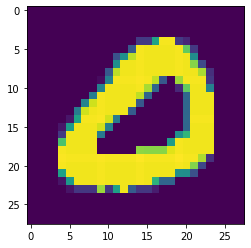

5


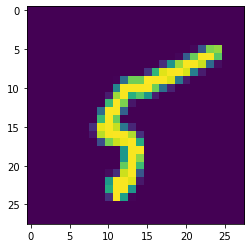

5


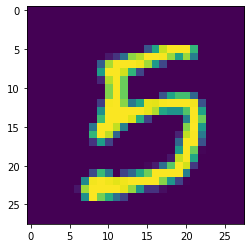

2


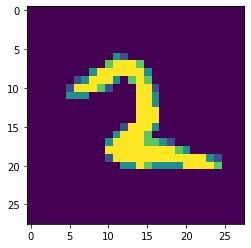

8


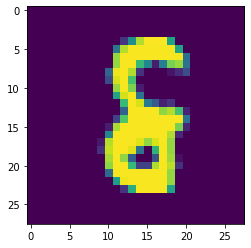

In [54]:
# Explore data
show5(vtraining_set)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [55]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [56]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Instantiate the model
net = NeuralNetwork().to(device)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [57]:
# Set the number of epochs and print frequency
num_epochs = 10
print_freq = 250
loss_list  = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(training_set, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss
        running_loss += loss.item()

        # Print the loss at the specified frequency
        if i % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            loss_list.append(avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(training_set)}], Loss: {avg_loss}")
            running_loss = 0.0


Epoch [1/10], Batch [250/938], Loss: 0.48391855317354204
Epoch [1/10], Batch [500/938], Loss: 0.13173090466856957
Epoch [1/10], Batch [750/938], Loss: 0.08722678227350115
Epoch [2/10], Batch [250/938], Loss: 0.06428600304014981
Epoch [2/10], Batch [500/938], Loss: 0.05855784033797681
Epoch [2/10], Batch [750/938], Loss: 0.05120960372965783
Epoch [3/10], Batch [250/938], Loss: 0.03491311425622553
Epoch [3/10], Batch [500/938], Loss: 0.04351742791384459
Epoch [3/10], Batch [750/938], Loss: 0.038208319837227465
Epoch [4/10], Batch [250/938], Loss: 0.021718165126629174
Epoch [4/10], Batch [500/938], Loss: 0.029368039527907966
Epoch [4/10], Batch [750/938], Loss: 0.030279900689492933
Epoch [5/10], Batch [250/938], Loss: 0.020039597869850694
Epoch [5/10], Batch [500/938], Loss: 0.023508670779701788
Epoch [5/10], Batch [750/938], Loss: 0.023007243909290993
Epoch [6/10], Batch [250/938], Loss: 0.01658562962608994
Epoch [6/10], Batch [500/938], Loss: 0.01824447289510863
Epoch [6/10], Batch [750

Plot the training loss (and validation loss/accuracy, if recorded).

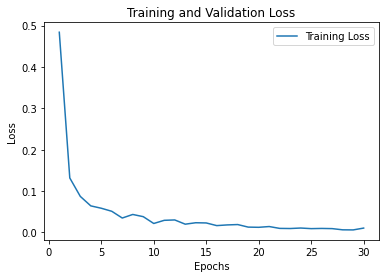

In [58]:
epochs = range(1, len(loss_list) + 1)

# Plot training loss
plt.plot(epochs, loss_list, label='Training Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [59]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    batch_size = 20

    model.eval() # test the model with dropout layers off
    for i, data in enumerate(training_set, 0):
        if torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
            
        images, labels = data[0].to(device), data[1].to(device)
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(testing_data)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")


In [60]:
test(net)

For NeuralNetwork :
Test Loss: 0.0010125693412503097
Correctly predicted per class : [1889.0, 2047.0, 1868.0, 1918.0, 1810.0, 1681.0, 1853.0, 1978.0, 1822.0, 1828.0], Total correctly perdicted : 18694.0
Total Predictions per class : [1890.0, 2048.0, 1875.0, 1944.0, 1822.0, 1684.0, 1858.0, 1982.0, 1827.0, 1830.0], Total predictions to be made : 18760.0

Test Accuracy of class 0 : 99.94708994708995% where 1889 of 1890 were predicted correctly
Test Accuracy of class 1 : 99.951171875% where 2047 of 2048 were predicted correctly
Test Accuracy of class 2 : 99.62666666666667% where 1868 of 1875 were predicted correctly
Test Accuracy of class 3 : 98.66255144032922% where 1918 of 1944 were predicted correctly
Test Accuracy of class 4 : 99.34138309549945% where 1810 of 1822 were predicted correctly
Test Accuracy of class 5 : 99.82185273159145% where 1681 of 1684 were predicted correctly
Test Accuracy of class 6 : 99.73089343379978% where 1853 of 1858 were predicted correctly
Test Accuracy of cla

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [63]:
# Set the number of epochs and print frequency
num_epochs = 10
print_freq = 250
loss_list  = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(training_set, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss
        running_loss += loss.item()

        # Print the loss at the specified frequency
        if i % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            loss_list.append(avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(training_set)}], Loss: {avg_loss}")
            running_loss = 0.0

Epoch [1/10], Batch [250/938], Loss: 0.007154360772105065
Epoch [1/10], Batch [500/938], Loss: 0.007763958789223579
Epoch [1/10], Batch [750/938], Loss: 0.00462210742098614
Epoch [2/10], Batch [250/938], Loss: 0.004738770134841616
Epoch [2/10], Batch [500/938], Loss: 0.009570846140533832
Epoch [2/10], Batch [750/938], Loss: 0.008191287088327955
Epoch [3/10], Batch [250/938], Loss: 0.0024410665006689668
Epoch [3/10], Batch [500/938], Loss: 0.0044477476232763135
Epoch [3/10], Batch [750/938], Loss: 0.00915548441975352
Epoch [4/10], Batch [250/938], Loss: 0.003468924865816007
Epoch [4/10], Batch [500/938], Loss: 0.006782301050117894
Epoch [4/10], Batch [750/938], Loss: 0.0044923530381684035
Epoch [5/10], Batch [250/938], Loss: 0.004673683358289736
Epoch [5/10], Batch [500/938], Loss: 0.005674659586539974
Epoch [5/10], Batch [750/938], Loss: 0.0038785599068551163
Epoch [6/10], Batch [250/938], Loss: 0.004545804773386863
Epoch [6/10], Batch [500/938], Loss: 0.004009780638048028
Epoch [6/10]

In [64]:
test(net)

For NeuralNetwork :
Test Loss: 0.0006752355296030374
Correctly predicted per class : [1800.0, 2098.0, 1914.0, 1938.0, 1801.0, 1695.0, 1794.0, 1989.0, 1827.0, 1857.0], Total correctly perdicted : 18713.0
Total Predictions per class : [1809.0, 2101.0, 1922.0, 1938.0, 1801.0, 1697.0, 1794.0, 2014.0, 1827.0, 1857.0], Total predictions to be made : 18760.0

Test Accuracy of class 0 : 99.50248756218906% where 1800 of 1809 were predicted correctly
Test Accuracy of class 1 : 99.85721085197525% where 2098 of 2101 were predicted correctly
Test Accuracy of class 2 : 99.5837669094693% where 1914 of 1922 were predicted correctly
Test Accuracy of class 3 : 100.0% where 1938 of 1938 were predicted correctly
Test Accuracy of class 4 : 100.0% where 1801 of 1801 were predicted correctly
Test Accuracy of class 5 : 99.88214496169711% where 1695 of 1697 were predicted correctly
Test Accuracy of class 6 : 100.0% where 1794 of 1794 were predicted correctly
Test Accuracy of class 7 : 98.75868917576962% where 

In [ ]:
test(net)

## Saving your model
Using `torch.save`, save your model for future loading.

In [62]:
torch.save(net.state_dict(), "model.pth")